In [1]:
import numpy as np
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertConfig, BertModel
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
images = []
descriptions = []
emotions = []
emotion_dic = {"positive":2, "negative":1, "neutral":0}
e_dataframe = pd.read_csv("./data/train.txt")
pre_trained = 'bert-base-uncased'
token = BertTokenizer.from_pretrained(pre_trained)

for i in range(e_dataframe.shape[0]):
    try:
        idx = e_dataframe.iloc[i]['guid']
        emotion = e_dataframe.iloc[i]['tag']
        img = Image.open('./data/data/' + str(idx) + '.jpg')
        img = img.resize((224,224),Image.ANTIALIAS)
        image = np.asarray(img, dtype = 'float32')
        with open('./data/data/' + str(idx) + '.txt', encoding='gbk') as fp:
            description = fp.read()
        images.append(image.transpose(2,0,1))
        descriptions.append(description)
        emotions.append(emotion_dic[emotion])
    except:
        continue

In [3]:
pre_trained = 'bert-base-uncased'
token = BertTokenizer.from_pretrained(pre_trained)

In [4]:
def text2emb(texts):
    data = token.batch_encode_plus(batch_text_or_text_pairs = texts, 
                                   truncation=True, padding='max_length', max_length=32,
                                   return_tensors='pt')
    input_ids = data['input_ids']
    attention_mask = data["attention_mask"]
    return input_ids, attention_mask

In [5]:
image_and_txt = [(images[i], descriptions[i]) for i in range(len(images))]
x_train, x_test, emotion_train, emotion_test = train_test_split(image_and_txt, emotions, test_size=0.2, random_state=0)
image_train, txt_train = [x_train[i][0] for i in range(len(x_train))], [x_train[i][1] for i in range(len(x_train))]
image_test, txt_test = [x_test[i][0] for i in range(len(x_test))], [x_test[i][1] for i in range(len(x_test))]

In [6]:
class Lab5Dataset():
    def __init__(self, images, descriptions, emotions):
        self.images = images
        self.input_ids, self.attention_masks = text2emb(descriptions)
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        input_id = self.input_ids[index]
        attention_mask = self.attention_masks[index]
        emotion = self.emotions[index]
        return image, input_id, attention_mask, emotion

    def __len__(self):
        return len(self.images)

In [7]:
train_dataset = Lab5Dataset(image_train, txt_train, emotion_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataset = Lab5Dataset(image_test, txt_test, emotion_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = True)

### 尝试直接拼接

In [32]:
class concatModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.linear1 = nn.Linear(768, 128)
        self.linear2 = nn.Linear(1000, 128)
        self.linear = nn.Linear(256, 3)
        self.relu = nn.ReLU()

    def forward(self, input_ids, input_mask, img):
        out = self.bert(input_ids = input_ids, attention_mask = input_mask) 
        out = out.last_hidden_state[:,0,:]
        out.view(out.shape[0], -1)
        txt_out = self.linear1(out)
        txt_out = self.relu(txt_out)
        img_out = self.resnet(img)
        img_out = self.linear2(img_out)
        img_out = self.relu(img_out)
        out = torch.cat((txt_out, img_out), dim=-1)
        out = self.linear(out)
        return out

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = concatModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr = 1e-6)
Loss = nn.CrossEntropyLoss()
train_acc = []
test_acc = []
for epoch in range(15):
    for batch_idx, (data, idx, mask, target) in enumerate(train_dataloader):
        data, idx, mask, target = data.to(device), idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask, data)
        optimizer.zero_grad()
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx+1, len(train_dataloader), 100. * (batch_idx+1) / len(train_dataloader), loss.item()))

    correct = 0
    for data, idx, mask, target in train_dataloader:
        data, idx, mask, target = data.to(device), idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask, data)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    train_acc.append(correct / len(image_train))
    print('Train Accuracy: {:.6f}'.format(correct / len(image_train)))

    correct = 0
    for data, idx, mask, target in test_dataloader:
        data, idx, mask, target = data.to(device), idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask, data)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    test_acc.append(correct / len(image_test))
    print('Test Accuracy: {:.6f}'.format(correct / len(image_test)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train Epoch: 0 [50/200 (25%)]	Loss: 0.997630
Train Epoch: 0 [100/200 (50%)]	Loss: 1.139396
Train Epoch: 0 [150/200 (75%)]	Loss: 0.823081
Train Epoch: 0 [200/200 (100%)]	Loss: 0.775791
Train Accuracy: 0.583620
Test Accuracy: 0.626250
Train Epoch: 1 [50/200 (25%)]	Loss: 0.831159
Train Epoch: 1 [100/200 (50%)]	Loss: 0.934349
Train Epoch: 1 [150/200 (75%)]	Loss: 0.815185
Train Epoch: 1 [200/200 (100%)]	Loss: 0.984878
Train Accuracy: 0.598625
Test Accuracy: 0.625000
Train Epoch: 2 [50/200 (25%)]	Loss: 0.715762
Train Epoch: 2 [100/200 (50%)]	Loss: 0.841816
Train Epoch: 2 [150/200 (75%)]	Loss: 0.850486
Train Epoch: 2 [200/200 (100%)]	Loss: 0.729872
Train Accuracy: 0.627071
Test Accuracy: 0.658750
Train Epoch: 3 [50/200 (25%)]	Loss: 0.738528
Train Epoch: 3 [100/200 (50%)]	Loss: 0.894050
Train Epoch: 3 [150/200 (75%)]	Loss: 0.781102
Train Epoch: 3 [200/200 (100%)]	Loss: 0.560578
Train Accuracy: 0.685214
Test Accuracy: 0.686250
Train Epoch: 4 [50/200 (25%)]	Loss: 0.727217
Train Epoch: 4 [100/200

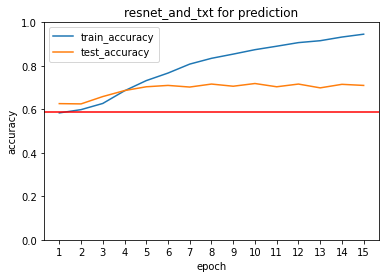

In [34]:
plt.plot(train_acc, label="train_accuracy")
plt.plot(test_acc, label="test_accuracy")
plt.axhline(Counter(emotion_train)[2]/len(emotion_train), color='red')
plt.title("resnet_and_txt for prediction")
plt.xlabel("epoch")
plt.xticks(range(15), range(1, 16))
plt.ylabel("accuracy")
plt.ylim(ymin=0, ymax=1)
plt.legend()
plt.savefig('./concat_model.jpg')
plt.show()

### 尝试动态加权

In [8]:
class attentionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.linear1 = nn.Linear(768, 128)
        self.linear2 = nn.Linear(1000, 128)
        self.query_img = nn.Linear(128, 1)
        self.query_txt = nn.Linear(128, 1)
        self.linear = nn.Linear(128, 3)
        self.relu = nn.ReLU()

    def forward(self, input_ids, input_mask, img):
        out = self.bert(input_ids = input_ids, attention_mask = input_mask) 
        out = out.last_hidden_state[:,0,:]
        out.view(out.shape[0], -1)
        txt_out = self.linear1(out)
        txt_out = self.relu(txt_out)
        img_out = self.resnet(img)
        img_out = self.linear2(img_out)
        img_out = self.relu(img_out)
        img_w = self.query_img(img_out)
        txt_w = self.query_txt(txt_out)
        final_out = img_w * img_out + txt_w * txt_out
        out = self.linear(final_out)
        
        return out

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = attentionModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr = 1e-6)
Loss = nn.CrossEntropyLoss()
train_acc = []
test_acc = []
for epoch in range(15):
    for batch_idx, (data, idx, mask, target) in enumerate(train_dataloader):
        data, idx, mask, target = data.to(device), idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask, data)
        optimizer.zero_grad()
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx+1, len(train_dataloader), 100. * (batch_idx+1) / len(train_dataloader), loss.item()))

    correct = 0
    for data, idx, mask, target in train_dataloader:
        data, idx, mask, target = data.to(device), idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask, data)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    train_acc.append(correct / len(image_train))
    print('Train Accuracy: {:.6f}'.format(correct / len(image_train)))

    correct = 0
    for data, idx, mask, target in test_dataloader:
        data, idx, mask, target = data.to(device), idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask, data)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    test_acc.append(correct / len(image_test))
    print('Test Accuracy: {:.6f}'.format(correct / len(image_test)))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental featu

Train Epoch: 0 [50/200 (25%)]	Loss: 1.024486
Train Epoch: 0 [100/200 (50%)]	Loss: 1.062915
Train Epoch: 0 [150/200 (75%)]	Loss: 1.061482
Train Epoch: 0 [200/200 (100%)]	Loss: 0.622344
Train Accuracy: 0.591435
Test Accuracy: 0.625000
Train Epoch: 1 [50/200 (25%)]	Loss: 0.512569
Train Epoch: 1 [100/200 (50%)]	Loss: 0.678748
Train Epoch: 1 [150/200 (75%)]	Loss: 0.791459
Train Epoch: 1 [200/200 (100%)]	Loss: 0.969694
Train Accuracy: 0.628947
Test Accuracy: 0.657500
Train Epoch: 2 [50/200 (25%)]	Loss: 0.809271
Train Epoch: 2 [100/200 (50%)]	Loss: 0.624306
Train Epoch: 2 [150/200 (75%)]	Loss: 0.969830
Train Epoch: 2 [200/200 (100%)]	Loss: 1.025358
Train Accuracy: 0.679587
Test Accuracy: 0.707500
Train Epoch: 3 [50/200 (25%)]	Loss: 0.675118
Train Epoch: 3 [100/200 (50%)]	Loss: 0.640642
Train Epoch: 3 [150/200 (75%)]	Loss: 0.658062
Train Epoch: 3 [200/200 (100%)]	Loss: 0.519692
Train Accuracy: 0.716161
Test Accuracy: 0.725000
Train Epoch: 4 [50/200 (25%)]	Loss: 0.927002
Train Epoch: 4 [100/200

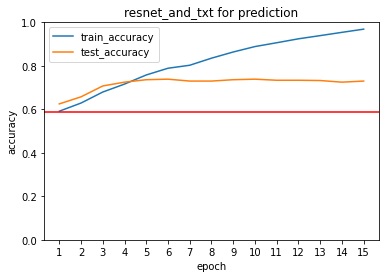

In [13]:
plt.plot(train_acc, label="train_accuracy")
plt.plot(test_acc, label="test_accuracy")
plt.axhline(Counter(emotion_train)[2]/len(emotion_train), color='red')
plt.title("resnet_and_txt for prediction")
plt.xlabel("epoch")
plt.xticks(range(15), range(1, 16))
plt.ylabel("accuracy")
plt.ylim(ymin=0, ymax=1)
plt.legend()
plt.savefig('./attention_model.jpg')
plt.show()

### 到底哪些预测不准

In [53]:
wrong_img = []
wrong_txt = []
wrong_emo = []
for img, idx, mask, target in test_dataloader:
    model.eval()
    img, idx, mask, target = img.to(device), idx.to(device), mask.to(device), target.to(device)
    output = model(idx, mask, img)
    output = torch.softmax(output, dim=1)
    for i in range(16):
        if np.argmax(output[i].tolist())!=target[i]:
            wrong_img.append(img[i].tolist())
            wrong_txt.append(token.decode(idx[i]))
            wrong_emo.append(target[i].tolist())
print(len(wrong_img))

216


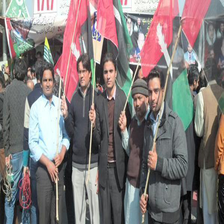

none political worker frm other party can beat # pppjiyalas # diehard # emotional # enthusiastic # ppppunjab # az
attitude is negative


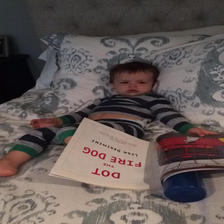

when you're overwhelmed with responsibilities ( part 2 )
attitude is negative


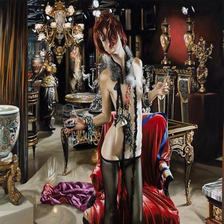

# homemade # girlfriend # slave # sub # submissive # slut # exposed -
attitude is positive


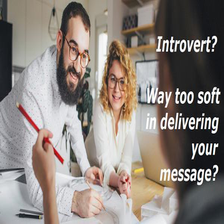

the power of powerless communication http : / / t. co / smsevqpoko @ inc # leadership # management # thwcxo http
attitude is positive


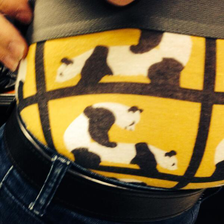

rt @ _ cheeseburguer : “ @ ashton5sos : here's some gossip... mikes underwear exposed # wow butt?
attitude is positive


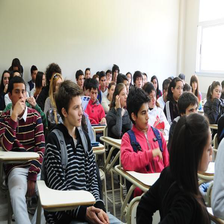

rt @ educaciontigre : el # cut ofrece carreras de cinco universidades y el # cbc de la uba.
attitude is negative


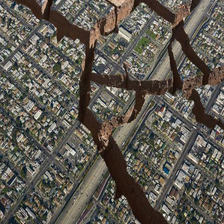

rt @ bigthink : with all the recent press surrounding " the big one, " why aren't we more alarmed? http : / /
attitude is negative


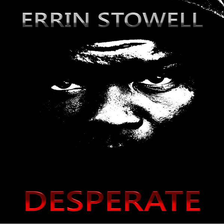

rt @ errin1970 : ch1 of my # thriller desperate is at http : / / t. co / taar7hmni7
attitude is negative


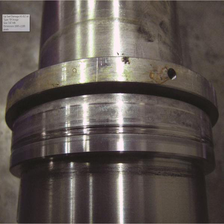

shafts already damaged by lip seals can upgrade to labtecta & 10. 5 years of bearing protection http : / / t. co / onr
attitude is negative


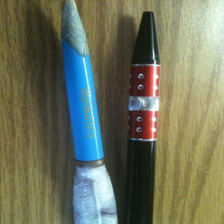

12 violets blue, 24 roses red, together purple & true, separate desolate, dead darkness rises who's on board?
attitude is neutral


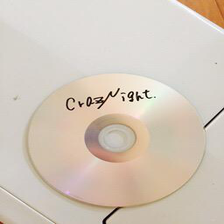

[UNK] [UNK] crazyのケストて [UNK] 安 [UNK] [UNK] [UNK] [UNK] [UNK] ってくたさい? http : / / …
attitude is negative


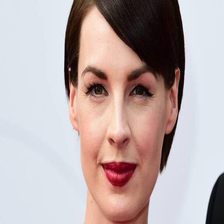

rt @ jessrainefans : article : jessica raine speaks out about " feeble roles for women " on tv
attitude is positive


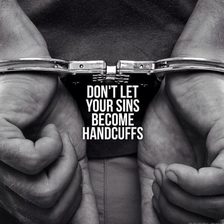

he is # compassionate, # kind and # forgiving. he hates the # sin, but would never # hate the # sinner. therefore,
attitude is negative


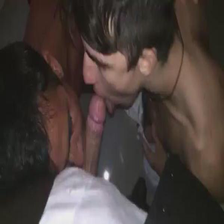

wow
attitude is negative


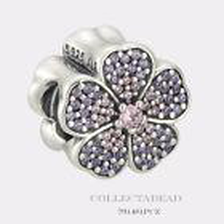

authentic pandora sterling silver sparkling primrose cz bead 791481pcz - full read by ebay
attitude is positive


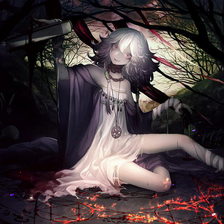

rt @ cin _ tw : [UNK] [UNK] [UNK] [UNK] # pixiv http : / / t. co / i4ceon6ty
attitude is positive


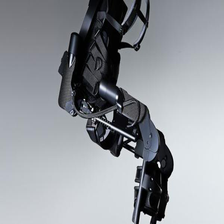

'walking robot'allows paralyzed man to move again # technews
attitude is neutral


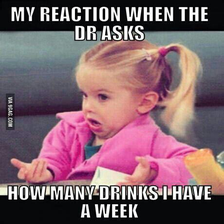

rt @ cowgirls360 : oops! # badgirl # cowgirls # drinking # drinks # party # wild # cantwai
attitude is negative


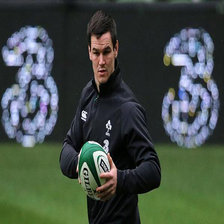

ireland cautious over johnny sexton but buoyant as france come calling ( photo : pa )
attitude is negative


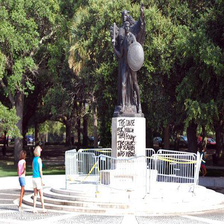

rt @ freedom _ daily : charleston confederate monument vandalized again — this time with obama quote # tcot
attitude is positive


In [24]:
for i in range(20):
    picture = Image.fromarray(np.uint8(wrong_img[i]).transpose(1,2,0))
    picture.show()
    txt = " ".join(wrong_txt[i].replace('[CLS]', "").replace('[SEP]', "").replace('[PAD]', "").split(" "))
    emo = ['neutral', 'negative', 'positive']
    print(txt.strip())
    print("attitude is " + emo[wrong_emo[i]])

### 预测

In [59]:
p_dataframe = pd.read_csv("./data/test_without_label.txt")
pred_list = p_dataframe['guid'].tolist()
emotion_dic = {"positive":2, "negative":1, "neutral":0}
emo = ["neutral", "negative", "positive"]

In [69]:
ans_list = []
for idx in pred_list:
    img = Image.open('./data/data/' + str(idx) + '.jpg')
    img = img.resize((224,224),Image.ANTIALIAS)
    image = np.asarray(img, dtype = 'float32')
    image = image.transpose(2,0,1)
    try:
        with open('./data/data/' + str(idx) + '.txt', encoding='gbk') as fp:
            description = fp.read()
    except:
        description = "RT @laurentbaheux: Cheetah's Eyes, Namibia 2004 ? print 40x40cm from 180 - contact@laurentbaheux.com - #Wild http:… "
    input_id, mask = text2emb([description])
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    y_pred = model(input_id.to(device), mask.to(device), torch.Tensor(image).to(device))
    sa = str(idx)+","+emo[y_pred[0].argmax(dim=-1).item()]
    ans_list.append(sa)

In [73]:
filename = "./data/test.txt"
with open(filename, 'a+') as file_object:
    file_object.write("guid,tag\n")
    for i in range(len(ans_list)):
        file_object.write(ans_list[i]+"\n")